In [1]:
import sys, os

os.chdir("../../")
sys.path.append("./src/data")
sys.path.append("./src/events")
sys.path.append("./src/probability")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from subprocess import call
from DC.importer import *
from DC.processer import *
from DC.main import get_all_events, get_events
from functions import perform_chisq, nufit_params_nsi, nufit_params_nsi_IO
from DC.event_processing import return_precomputed_nsi, get_deltachi, to_hist
from DC.event_processing import (
    list_of_params_nsi,
    get_param_list,
    get_marginalized_array,
)
from scipy.stats import chi2
from src.plotter import save, savethesis
import pickle
from scipy.interpolate import splrep, splev, sproot

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 400
matplotlib.rc("text", usetex=True)
matplotlib.rc("text.latex", preamble=r"\usepackage{amsmath}")
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] + np.diff(Ebins_2018) / 2

In [2]:
name = "5x5x1x1x1x9"
track = pickle.load(open(f"./pre_computed/H1_NO_DC_1_{name}.p", "rb"))
cascade = pickle.load(open(f"./pre_computed/H1_NO_DC_0_{name}.p", "rb"))
new = np.concatenate((cascade, track), axis=1)
new_name = f"H1_NO_DC_1_{name}.p".replace("_1_", "_")
pickle.dump(new, open(f"./pre_computed/{new_name}", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: './pre_computed/H1_NO_DC_1_2x5x1x1x1x9.p'

In [2]:
sigma_a = 0.25
sigma_b = 0.04
f = 1
ndim = 3
livetime = 3 * 365 * 24 * 3600  # Effective livetime table1 DC2019 2.45

ett = 7e-2
emt = 3e-2
eem = 3e-1
eet = 3e-1

In [3]:
marginalized_arrays_NO = []
marginalized_arrays_IO = []
nsi_param_range = []
for ordering in ["NO"]:
    for i, nsi_param in enumerate(["ett", "emt", "eem", "eet"]):
        ettN, emtN, eemN, eetN = 0, 0, 0, 0
        if nsi_param == "ett":
            ettN = 1
        elif nsi_param == "emt":
            emtN = 1
        elif nsi_param == "eem":
            eemN = 1
        elif nsi_param == "eet":
            eetN = 1

        dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range = (
            get_param_list(
                dm31N=5,
                th23N=5,
                ett_tuple=(-ett, ett, 9 * ettN + 1),
                emt_tuple=(-emt, emt, 9 * emtN + 1),
                eem_tuple=(-eem, eem, 9 * eemN + 1),
                eet_tuple=(-eet, eet, 9 * eetN + 1),
                IO=False if ordering == "NO" else True,
            )
        )

        param_dict = nufit_params_nsi_IO if ordering == "IO" else nufit_params_nsi
        param_list = list_of_params_nsi(
            param_dict,
            dm31_range,
            th23_range,
            ett_range,
            emt_range,
            eem_range,
            eet_range,
        )
        try:
            H1 = (
                pickle.load(
                    open(
                        f"./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p",
                        "rb",
                    )
                )
                * livetime
            )
            H0 = (
                pickle.load(open(f"./pre_computed/H0_{ordering}_DC.p", "rb")) * livetime
            )

            marg_array = get_marginalized_array(
                H1,
                dm31_range,
                th23_range,
                ett_range,
                emt_range,
                eem_range,
                eet_range,
                param_list,
                nsi_param,
                sigma_a,
                sigma_b,
                f,
            )
            if ordering == "NO":
                marginalized_arrays_NO.append(marg_array)
            elif ordering == "IO":
                marginalized_arrays_IO.append(marg_array)
            param_range = (
                ettN * ett_range
                + emtN * emt_range
                + eemN * eem_range
                + eetN * eet_range
            )  # Assumes 3d plot
            nsi_param_range.append(param_range)
        except FileNotFoundError:
            pass  # No IO found

$\epsilon_{\tau\tau}$
90CL: [-0.025  0.044]
3sigma: []

$\epsilon_{\tau\tau}$
90CL: [-0.015  0.003]
3sigma: [0.014]

$\epsilon_{\tau\tau}$
90CL: [-0.049  0.055]
3sigma: [-0.121  0.115]

$\epsilon_{\tau\tau}$
90CL: [-0.049  0.132]
3sigma: [-0.166  0.198]



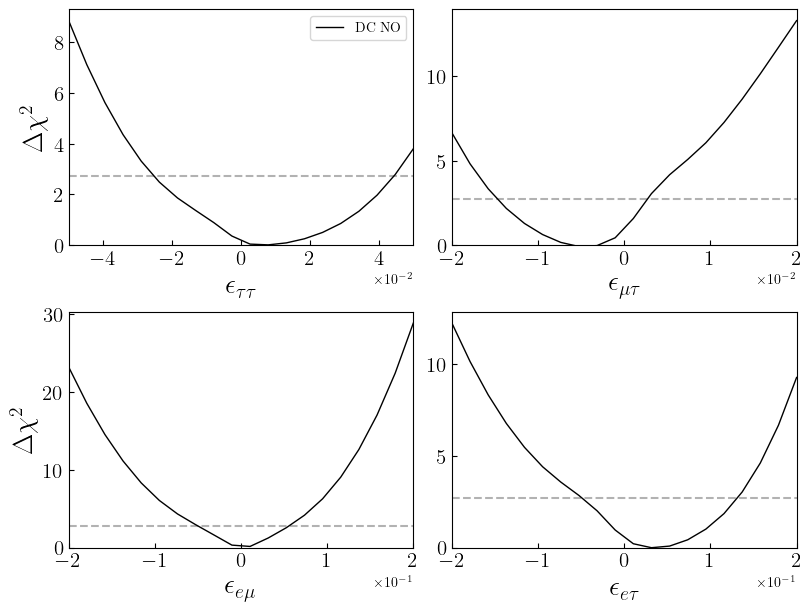

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [
    r"$\epsilon_{\tau\tau}$",
    r"$\epsilon_{\mu\tau}$",
    r"$\epsilon_{e\mu}$",
    r"$\epsilon_{e\tau}$",
]
demidovs = [demidov_ett, demidov_emt, demidov_eem, demidov_eet]
for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(), nsi_param_range[i].max(), 20)
    interpolated_e = splev(
        np.linspace(nsi_param_range[i].min(), nsi_param_range[i].max(), 20),
        splrep(nsi_param_range[i], marginalized_arrays_NO[i]),
    )
    # ax[i].plot(nsi_param_range[i], marginalized_arrays_NO[i], label='DC NO', color='k', lw=1)
    ax[i].plot(finer_e_range, interpolated_e, label="DC NO", color="k", lw=1)
    # ax[i].plot(nsi_param_range[i], marginalized_arrays_IO[i], label='IO', color='green')
    ax[i].axhline(chi2.ppf(0.9, 1), alpha=0.3, c="black", ls="--")

    # ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    # ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=20)
    ax[i].tick_params(labelsize=15, axis="both", direction="in", which="both")
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

    cl_90_bounds = splrep(
        nsi_param_range[i], marginalized_arrays_NO[i] - chi2.ppf(0.9, 1)
    )
    three_sigma_bounds = splrep(
        nsi_param_range[i], marginalized_arrays_NO[i] - chi2.ppf(0.9973, 1)
    )
    print(
        xlabels[i]
        + "\n"
        + f"90CL: {sproot(cl_90_bounds)}\n"
        + f"3sigma: {sproot(three_sigma_bounds)}\n"
    )
ax[0].set_ylabel(r"$\Delta \chi^2$", fontsize=20)
ax[2].set_ylabel(r"$\Delta \chi^2$", fontsize=20)
ax[0].legend()
save(fig, "DC_3D_NO")
savethesis(fig, "DC_3D_NO")

In [3]:
ordering = "NO"
dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range = get_param_list(
    dm31N=5,
    th23N=5,
    ett_tuple=(-ett, ett, 1),
    emt_tuple=(-emt, emt, 1),
    eem_tuple=(-eem, eem, 1),
    eet_tuple=(-eet, eet, 10),
    IO=False if ordering == "NO" else True,
)
param_dict = nufit_params_nsi_IO if ordering == "IO" else nufit_params_nsi
param_list = list_of_params_nsi(
    param_dict, dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range
)

H1 = (
    pickle.load(
        open(
            f"./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p",
            "rb",
        )
    )
    * livetime
)
H0 = pickle.load(open(f"./pre_computed/H0_{ordering}_DC.p", "rb")) * livetime

marginalized_deltachi = get_marginalized_array(
    H1,
    dm31_range,
    th23_range,
    ett_range,
    emt_range,
    eem_range,
    eet_range,
    param_list,
    "eet",
    sigma_a,
    sigma_b,
    f,
)

In [10]:
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)

In [11]:
marginalized_deltachi

array([39.327, 15.505,  6.783,  2.56 ,  0.292,  0.   ,  3.17 , 13.776, 45.92 ])

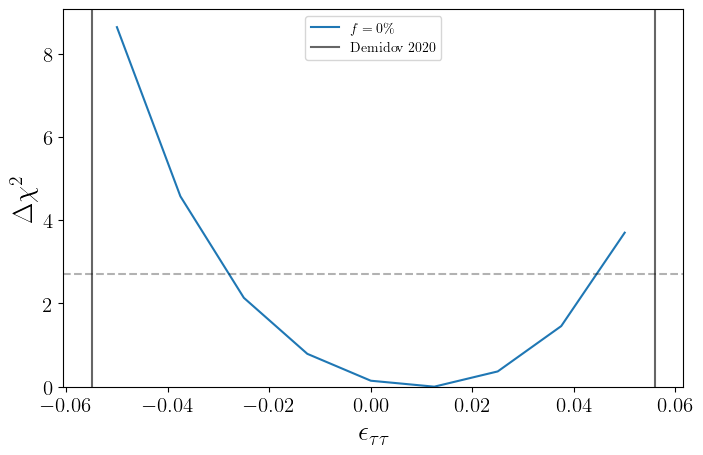

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(ett_range, marginalized_deltachi, label=r"$f = 0\%$")
plt.axhline(chi2.ppf(0.9, 1), alpha=0.3, c="black", ls="--")
# plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov_ett[0], alpha=0.6, c="black", label=r"Demidov 2020")
plt.axvline(demidov_ett[1], alpha=0.6, c="black")


# plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
# plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
# plt.xlim((ett_range.min(), ett_range.max()))
plt.xlabel(r"$\epsilon_{\tau\tau}$", fontsize=20)
plt.ylabel(r"$\Delta \chi^2$", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
save(fig, "DC_3D_ett")

(-0.015, 0.005)


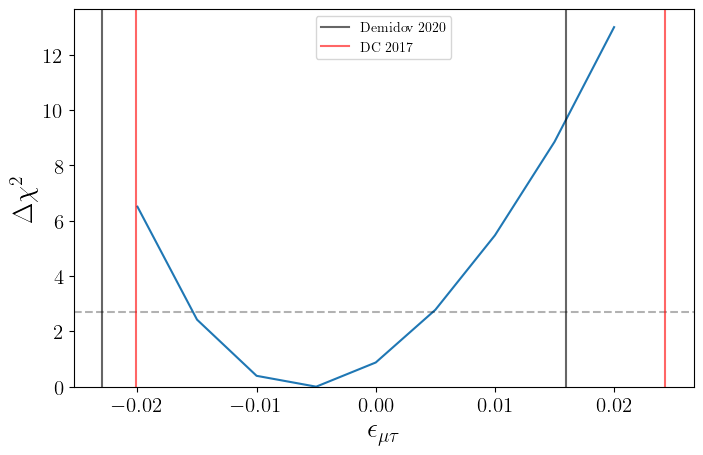

In [30]:
salvado = (-6e-3 * 3, 5.4e-3 * 3)
dc_2017 = (-6.7e-3 * 3, 8.1e-3 * 3)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(emt_range, deltachi_emt)
plt.axhline(chi2.ppf(0.9, 1), alpha=0.3, c="black", ls="--")

plt.axvline(demidov_emt[0], alpha=0.6, c="black", label=r"Demidov 2020")
plt.axvline(demidov_emt[1], alpha=0.6, c="black")

plt.axvline(dc_2017[0], alpha=0.6, c="red", label=r"DC 2017")
plt.axvline(dc_2017[1], alpha=0.6, c="red")

plt.ylim(bottom=0)

plt.xlabel(r"$\epsilon_{\mu\tau}$", fontsize=20)
plt.ylabel(r"$\Delta \chi^2$", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
print(get_best_fit(deltachi=deltachi_emt, p_range=emt_range, cl=0.9))
# save(fig, 'DC_3D_emt')

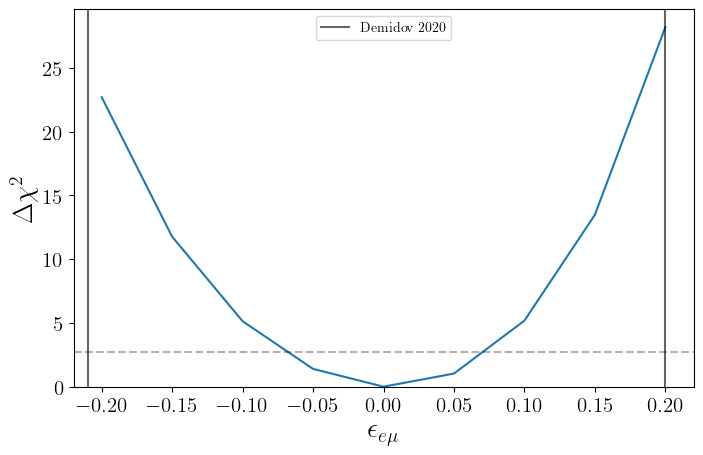

In [76]:
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(eem_range, marginalized_deltachi)
plt.axhline(chi2.ppf(0.9, 1), alpha=0.3, c="black", ls="--")

plt.axvline(demidov_eem[0], alpha=0.6, c="black", label=r"Demidov 2020")
plt.axvline(demidov_eem[1], alpha=0.6, c="black")


plt.ylim(bottom=0)

plt.xlabel(r"$\epsilon_{e\mu}$", fontsize=20)
plt.ylabel(r"$\Delta \chi^2$", fontsize=20)
plt.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()
# print(get_best_fit(deltachi=deltachi_eem , p_range = eem_range, cl=0.9))
# save(fig, 'DC_3D_eem')

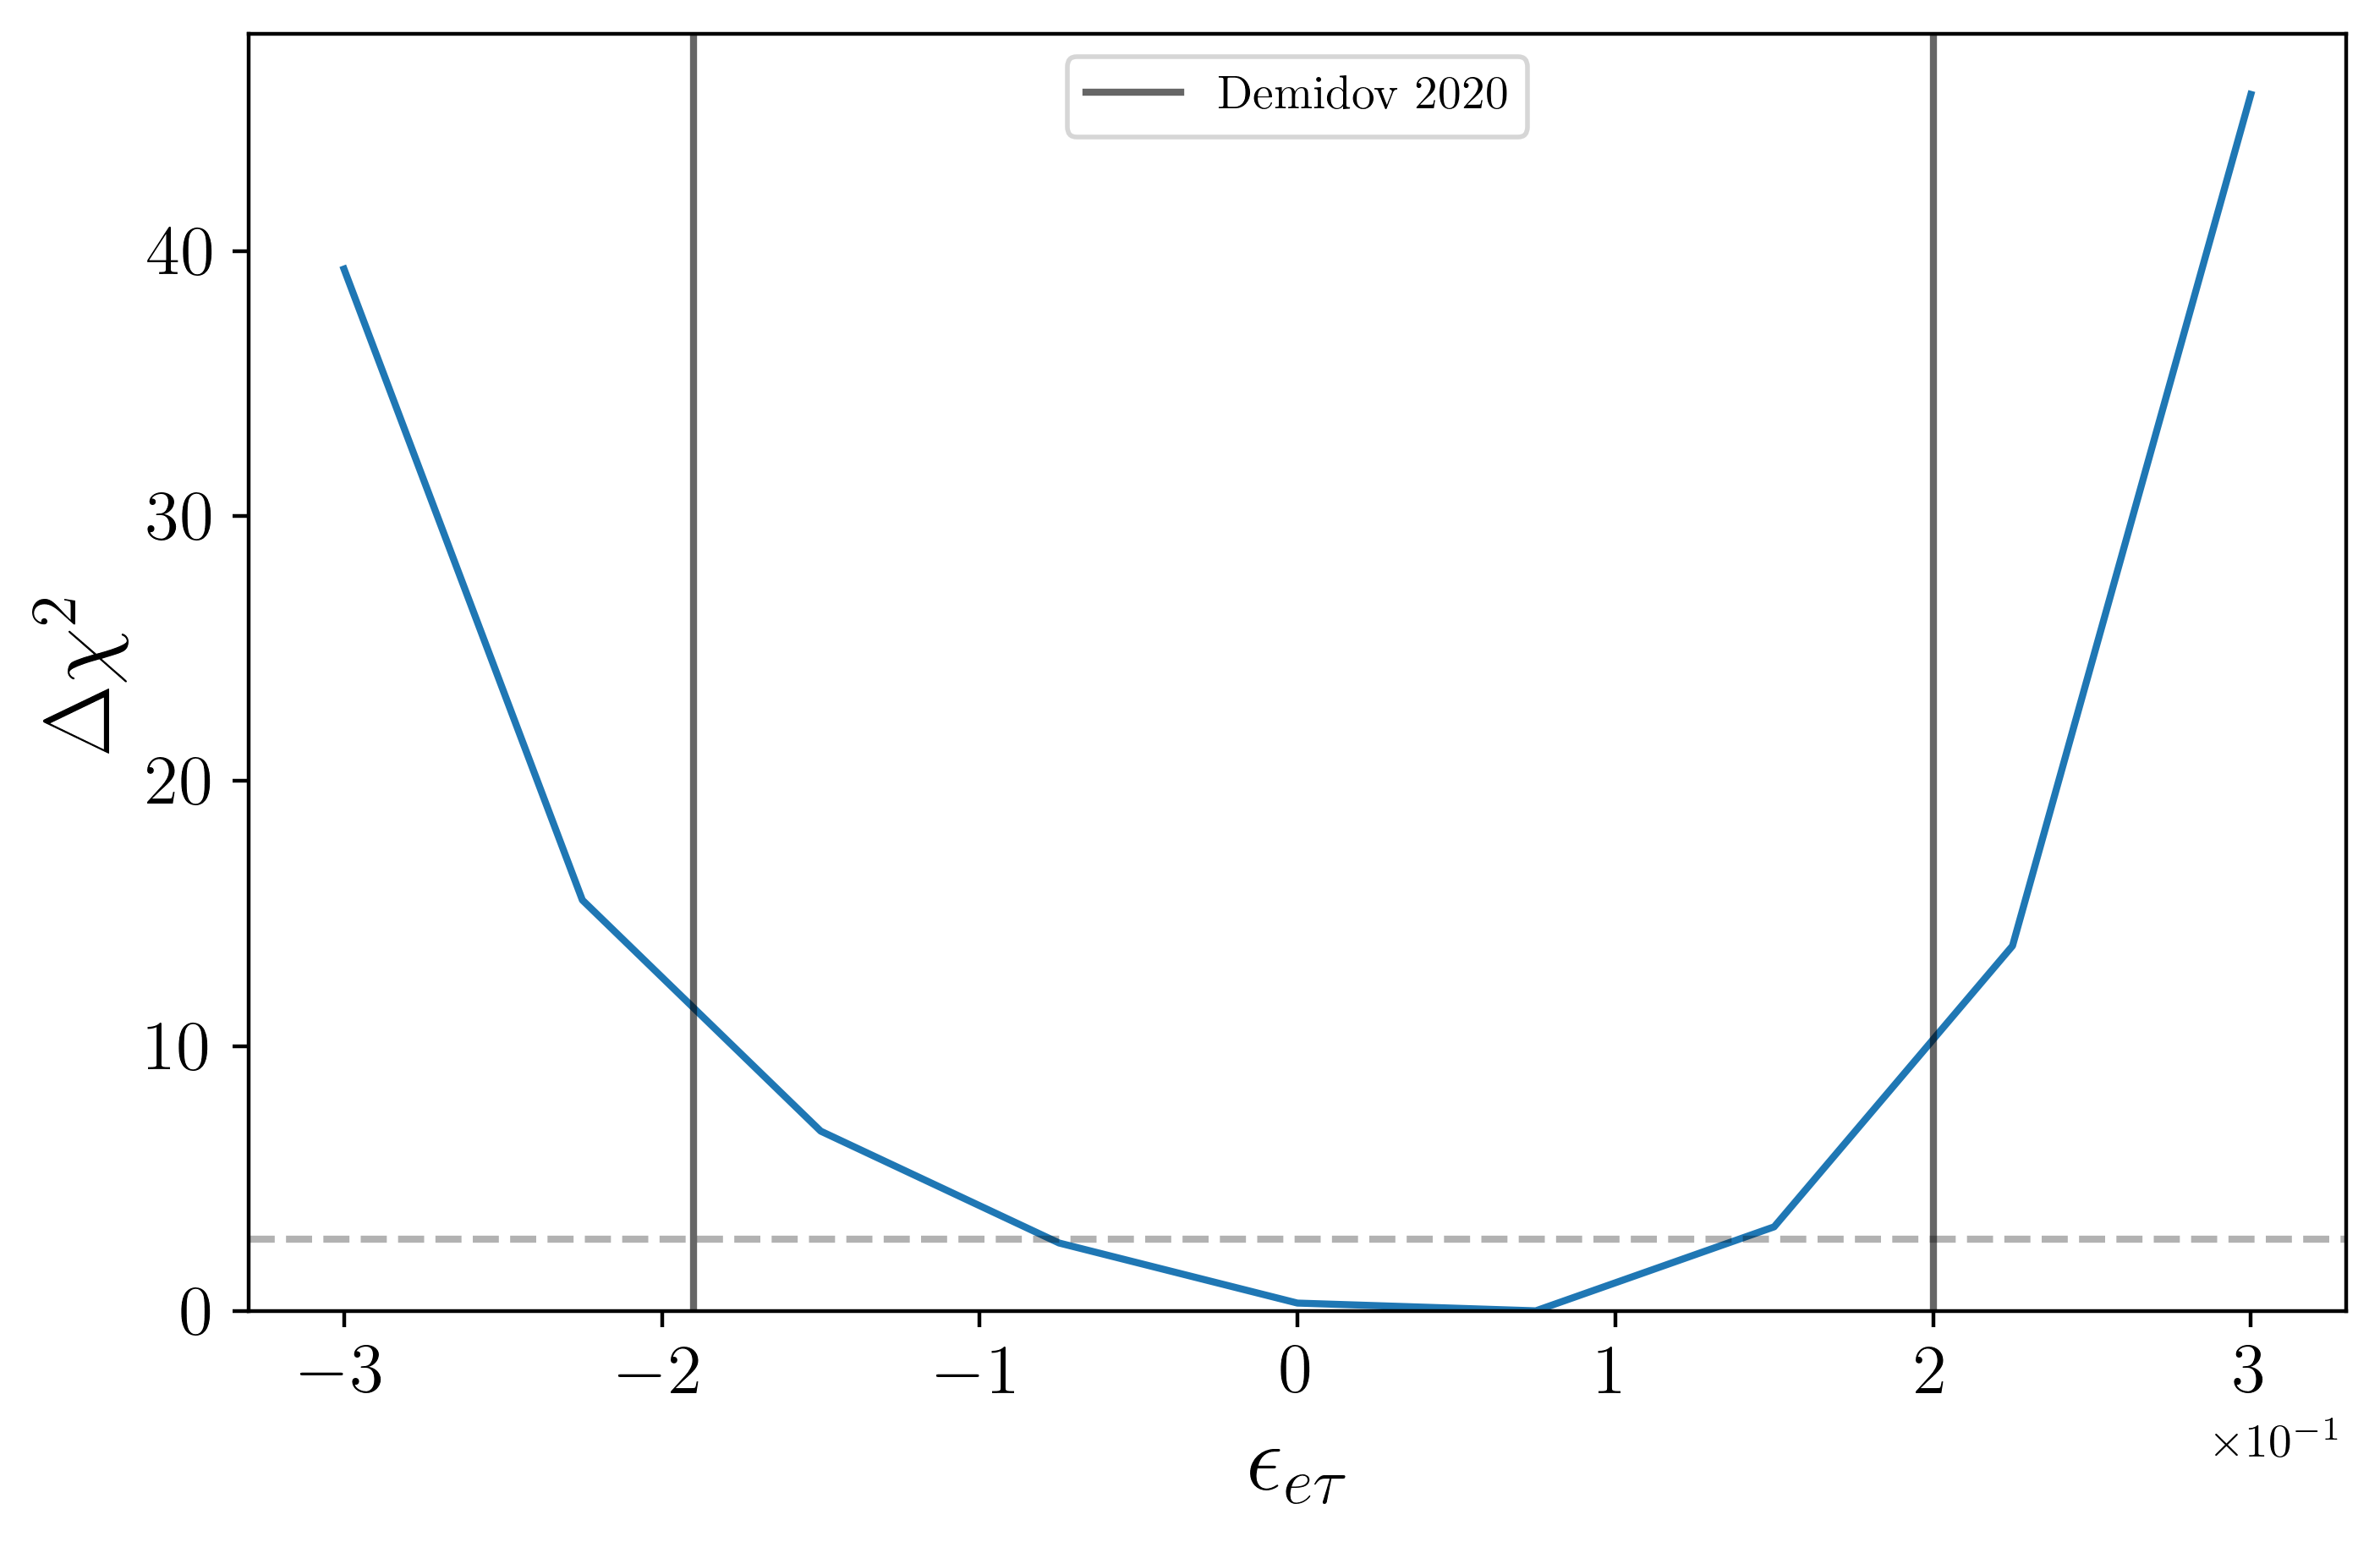

In [12]:
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(eet_range, marginalized_deltachi)
plt.axhline(chi2.ppf(0.9, 1), alpha=0.3, c="black", ls="--")

plt.axvline(demidov_eet[0], alpha=0.6, c="black", label=r"Demidov 2020")
plt.axvline(demidov_eet[1], alpha=0.6, c="black")


plt.ylim(bottom=0)

plt.xlabel(r"$\epsilon_{e\tau}$", fontsize=20)
plt.ylabel(r"$\Delta \chi^2$", fontsize=20)
plt.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()
# print(get_best_fit(deltachi=deltachi_eet , p_range = eet_range, cl=0.9))
# save(fig, 'DC_3D_eet')

In [2]:
from plotter import P_over_E_parameter

E_range = np.logspace(0, 2, 300)
plot_params = list_of_params_nsi(
    nufit_params_nsi,
    dm31_range=[nufit_params_nsi["dm_31"]],
    th23_range=[nufit_params_nsi["theta_23"]],
    emm_range=np.array([0]),
    emt_range=np.array([-1e-2, 0, 1e-2]),
)

In [31]:
from src.plotter import nsi_oscillogram, nsi_flux_oscillogram

z_range = np.linspace(-1, 0, 500)
E_range = np.logspace(0, np.log10(60), 500)

# Pex_neg, Pmx_neg, Paeax_neg,Pamax_neg = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[0])
# Pex_si, Pmx_si, Paeax_si,Pamax_si = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[1])
# Pex_pos, Pmx_pos, Paeax_pos,Pamax_pos = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[2])

Pmx_neg = pickle.load(open("./pre_computed/Pmx_neg.p", "rb"))
Pmx_pos = pickle.load(open("./pre_computed/Pmx_pos.p", "rb"))
# fluxratio_neg = nsi_flux_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[0])
# fluxratio_pos = nsi_flux_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[2])

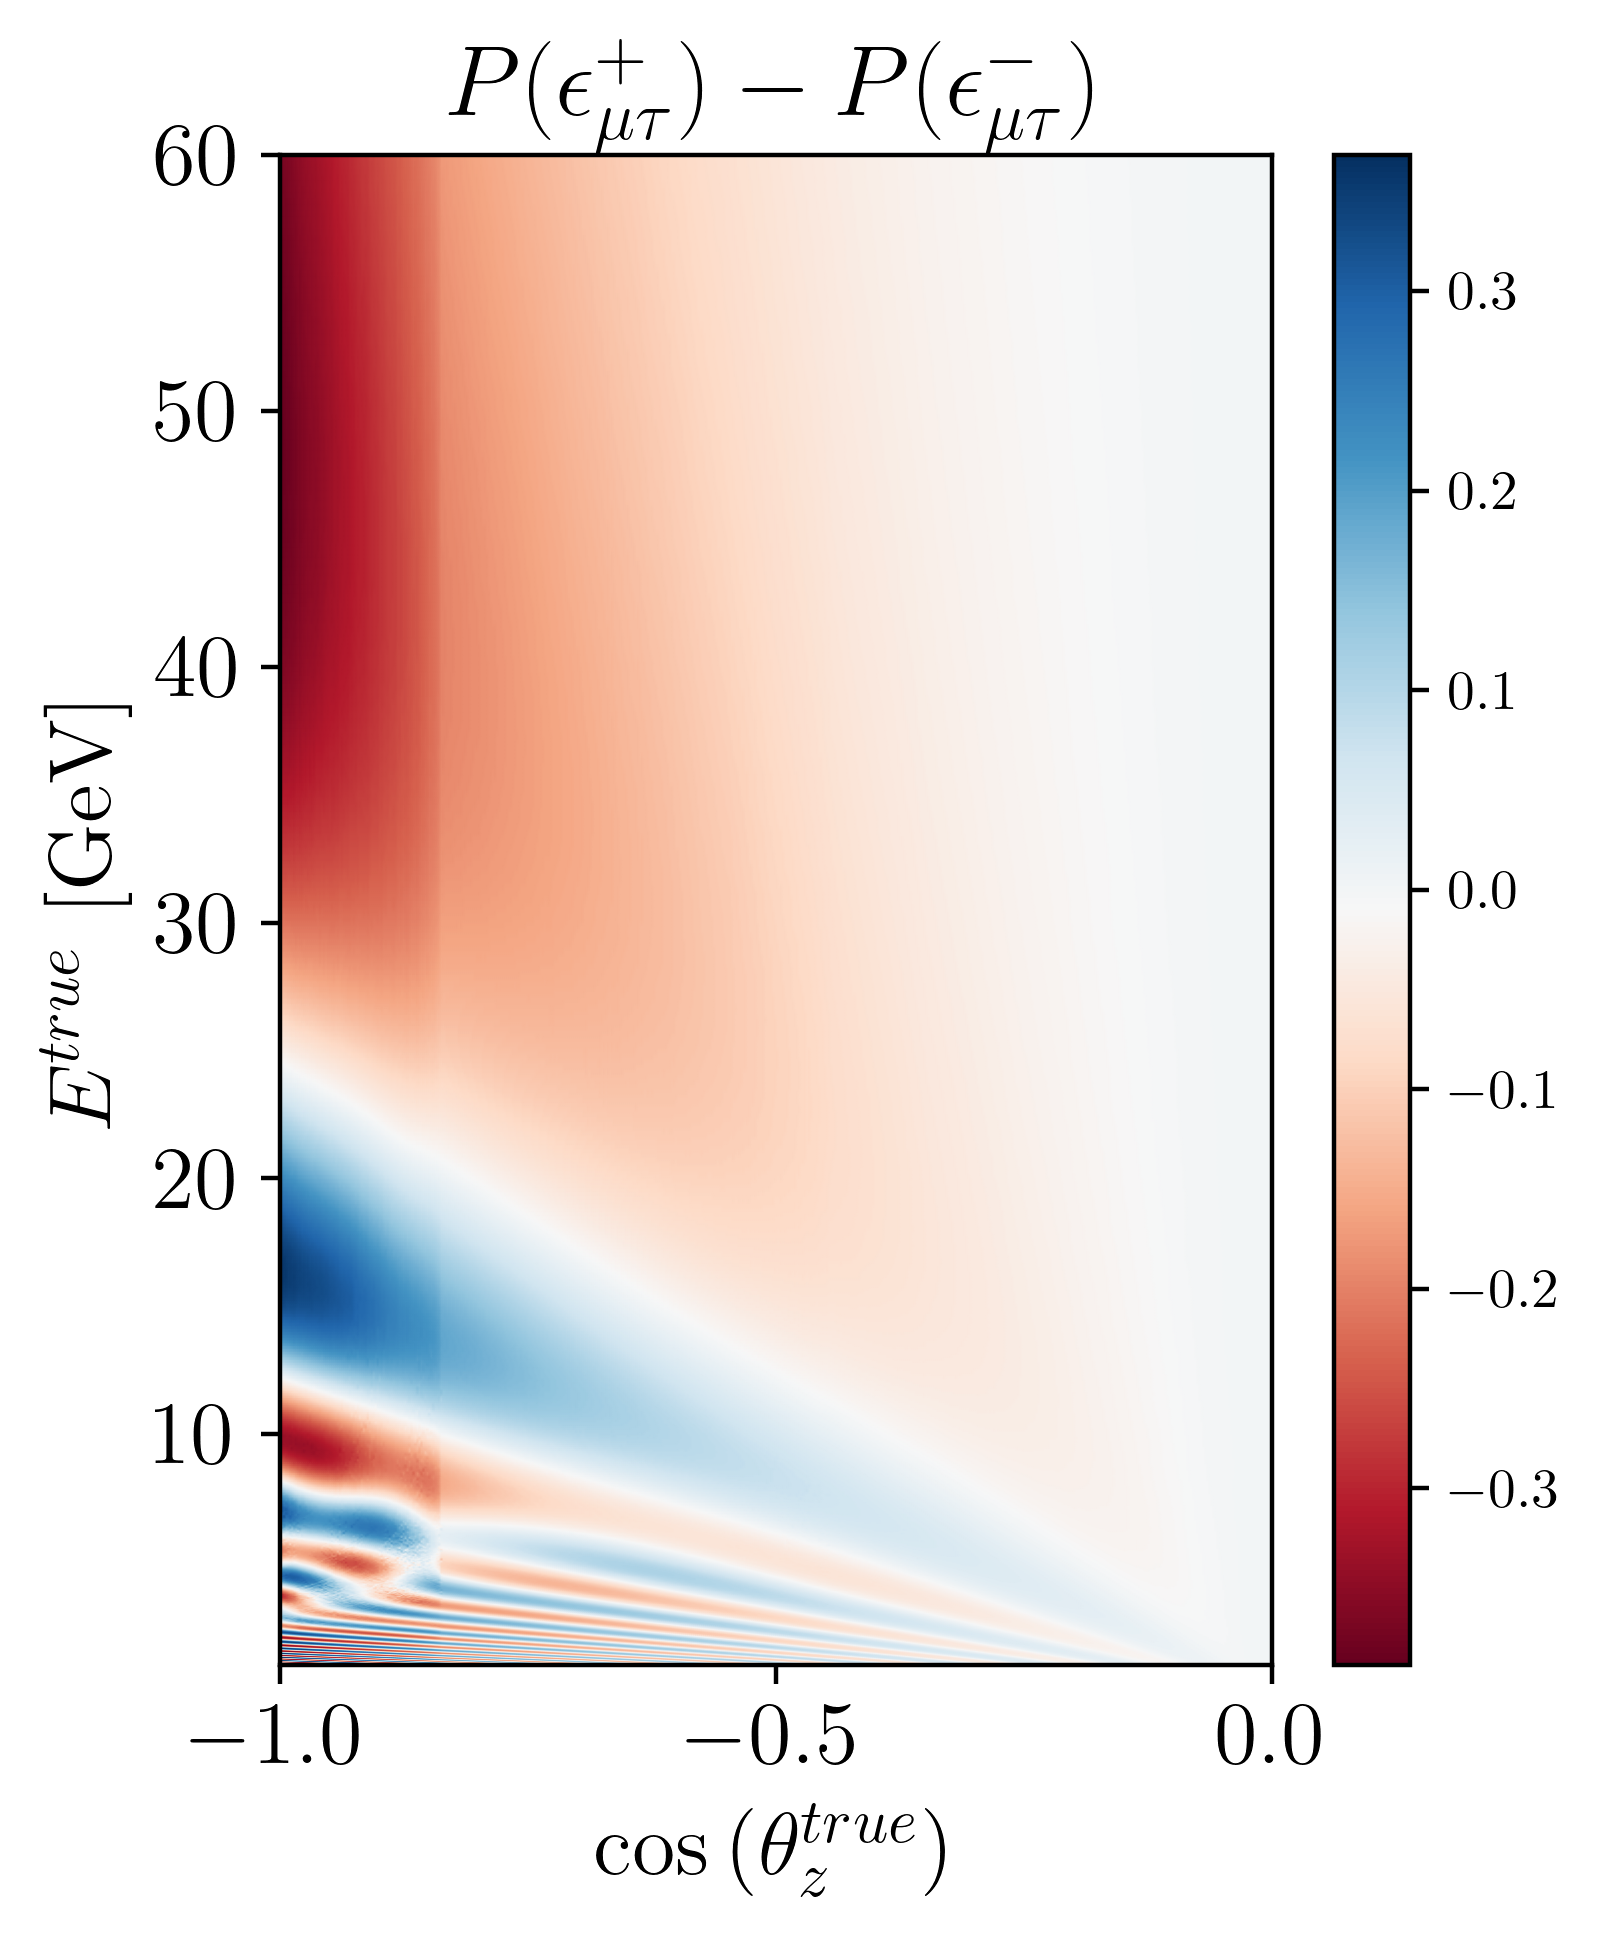

In [32]:
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
c = ax.pcolormesh(
    z_range,
    E_range,
    Pmx_pos[1].T - Pmx_neg[1].T,
    cmap="RdBu",
    edgecolor=None,
    shading="gouraud",
    rasterized=True,
)  # ,norm=colors.CenteredNorm(1))
ax.set_title(r"$P(\epsilon^+_{\mu\tau}) - P(\epsilon^-_{\mu\tau})$", fontsize=18)
ax.set_xlabel(r"$\cos{(\theta^{true}_z)}$", fontsize=16)
ax.tick_params(labelsize=16)
ax.set_ylabel(r"$E^{true}\,\,\mathrm{[GeV]}$", fontsize=16)
cbar = fig.colorbar(c, ax=ax)
plt.savefig("./article/figures/Pmm_asymmetry.pdf", bbox_inches="tight")

In [86]:
from plotter import P_over_E_parameter

E_range = np.logspace(0, 2, 100)
plot_params = list_of_params_nsi(
    nufit_params_nsi,
    dm31_range=[nufit_params_nsi["dm_31"]],
    th23_range=[nufit_params_nsi["theta_23"]],
    emt_range=np.array([0]),
    emm_range=np.array([-1e-2, 0, 1e-2]),
)
Pm = P_over_E_parameter(
    "e", param_dict_list=plot_params, E=E_range, zenith=-1, ndim=3, anti=False, nsi=True
)

In [87]:
E_range = np.logspace(0, 2, 5)
Pex_neg, Pmx_neg, Paeax_neg, Pamax_neg = nsi_oscillogram(
    E_range=E_range, z_range=z_range, params=plot_params[0]
)
Pex_si, Pmx_si, Paeax_si, Pamax_si = nsi_oscillogram(
    E_range=E_range, z_range=z_range, params=plot_params[1]
)
Pex_pos, Pmx_pos, Paeax_pos, Pamax_pos = nsi_oscillogram(
    E_range=E_range, z_range=z_range, params=plot_params[2]
)

fluxratio_neg = nsi_flux_oscillogram(
    E_range=E_range, z_range=z_range, params=plot_params[0]
)
fluxratio_pos = nsi_flux_oscillogram(
    E_range=E_range, z_range=z_range, params=plot_params[2]
)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
norm_factor = np.array([0.9, 0.9])
back_factor = np.array([0.15, 1])
for pid in [0, 1]:
    ax[0, pid].step(
        Ebins_2018,
        to_hist(no_osc_paper[pid]),
        color="blue",
        ls="--",
        alpha=0.6,
        label="DC no osc.",
        where="post",
    )
    ax[0, pid].step(
        Ebins_2018,
        to_hist(
            norm_factor[pid] * np.sum(no_osc[pid], axis=1) * livetime
            + back_factor[pid] * np.sum(background[pid], axis=1)
        ),
        color="green",
        ls="--",
        alpha=0.6,
        label="Me no osc.",
        where="post",
    )
    ax[0, pid].set_xscale("log")
    ax[1, pid].step(
        Ebins_2018,
        to_hist(H0_paper[pid]),
        color="blue",
        label=r"DC $3\nu$",
        where="post",
    )
    ax[1, pid].step(
        Ebins_2018,
        to_hist(norm_factor[pid] * np.sum(H0[pid], axis=1)),
        color="green",
        label=r"Me $3\nu$",
        where="post",
    )
    ax[1, pid].set_xscale("log")

ax[0, 0].set_title("Cascades", fontsize=20)
ax[0, 1].set_title("Tracks", fontsize=20)
ax[1, 0].set_xlabel("E [GeV]")
ax[1, 1].set_xlabel("E [GeV]")
ax[0, 0].legend()
ax[1, 0].legend()
fig.tight_layout()